# Assignment 3 — Teleport me your data

Course: Quantum Programming <br>
Author: Danis Alukaev <br>
Group: B19-DS-01 <br>
Email: d.alukaev@innopolis.university <br>

# Teleport my spectrogram!

In this task you will solve the following problem. Sender (let's call her Alice) wants to transfer some data vector to her mate Bob. She wants him to receive exactly her quantum state, and she wants to do it fast (with the speed of light, unfortunately she cannot do it [faster due to some theorems](https://www.forbes.com/sites/chadorzel/2016/05/04/the-real-reasons-quantum-entanglement-doesnt-allow-faster-than-light-communication/?sh=611ac4263a1e)).

Alice is an ingenious person, so before transmitting the data she converts the vector into a spectrogram, by running Quantum Fourier Transform. So, Bob's task will be to run an inverse version of this algorithm, before he can read the result.

Follow the notebook, complete the missing part and let Bob read the message teleported from Alice.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, BasicAer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from collections import Counter
import numpy as np

# the size of the register 
PROBLEM_SIZE = 4

First thing we do - we create a circiut for the communication channel. In the original simple algorithm we use 3 qubits: sender's (Alice), receiver's target (Bob's), and media qubit stored on the Alice's side (used to create a transitional entanglement of these 2 qubits).

In our implementation we will create REGISTERS instead of the qubits, and we will create corresponding classical registers.

In [2]:
q_alice = QuantumRegister(PROBLEM_SIZE, "alice")
q_media = QuantumRegister(PROBLEM_SIZE, "media")
q_bob = QuantumRegister(PROBLEM_SIZE, "bob")
c_alice = ClassicalRegister(PROBLEM_SIZE, "c_alice")
c_media = ClassicalRegister(PROBLEM_SIZE, "c_media")
c_bob = ClassicalRegister(PROBLEM_SIZE, "c_bob")

qc = QuantumCircuit(q_alice, q_media, q_bob, 
                    c_alice, c_media, c_bob)

## [20] Entangling qubits

Before sending the receiving qubits (`bob` register) to Bob, Alice needs to entangle them with the media qubits (`media` register). 

Please implement `entangle` and `reverse_entangle` functions. You may refer to [this tutorial](https://qiskit.org/textbook/ch-algorithms/teleportation.html) to refresh the explanation from the lecture.

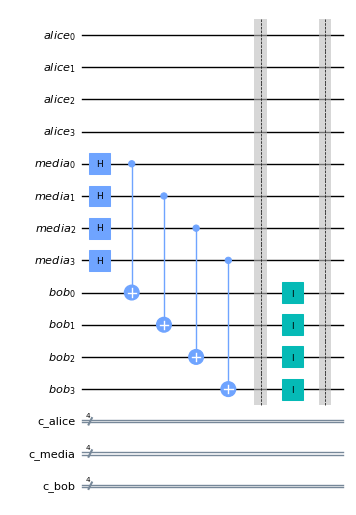

In [3]:
def entangle(qc, one, another):
    qc.h(one)
    qc.cnot(one, another)

# to implement this method please refer to 
# this tutorial https://qiskit.org/textbook/ch-algorithms/teleportation.html#how
def reverse_entangle(qc, one, another):
    qc.cnot(another, one)
    qc.h(another)

for a, b in zip(q_media, q_bob):
    entangle(qc, a, b)
    
qc.barrier()
# pretend we send these qubits to bob with this operation
qc.i(q_bob)
qc.barrier()
qc.draw('mpl', scale=0.5)

# [20] Enter the data

Alice wants to send these 8(16) numbers to Bob. She does not care about the scale, she cares about the shape only. So you may apply any norming factor.

```
0, 3, 5, 6, 6, 5, 3, 0, 1, 2, 3, 4, 5, 4, 3, 2
```

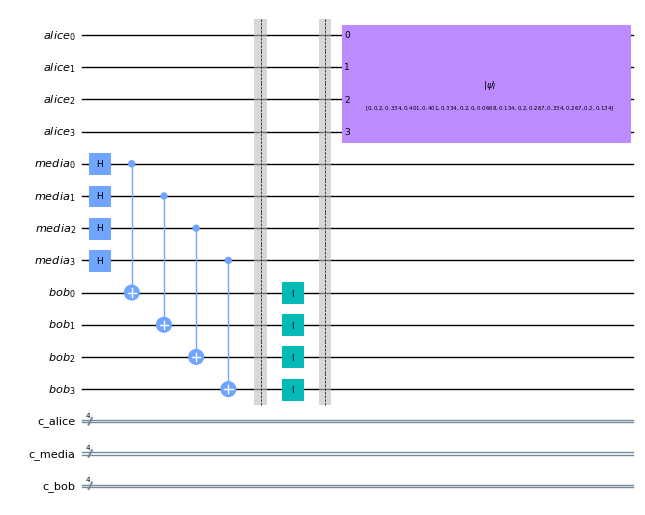

In [4]:
vector = np.array(
    [0., 3, 5, 6, 6, 5, 3, 0, 1, 2, 3, 4, 5, 4, 3, 2] * 4, 
    dtype=np.float64)

# this adjusts the size of the data depending on 
# the number of qubits you utilize in the solution
vector = vector[:2 ** PROBLEM_SIZE]

## TODO -- NORMALIZE the data vector and INITIALIZE the state of ALICE's qubits.
vector_norm = np.linalg.norm(vector)
vector_normed = vector / vector_norm

qc.initialize(vector_normed, q_alice[:])
qc.draw('mpl', scale=.5)

Let us check that the distribution you initialized is the same Alice wanted.

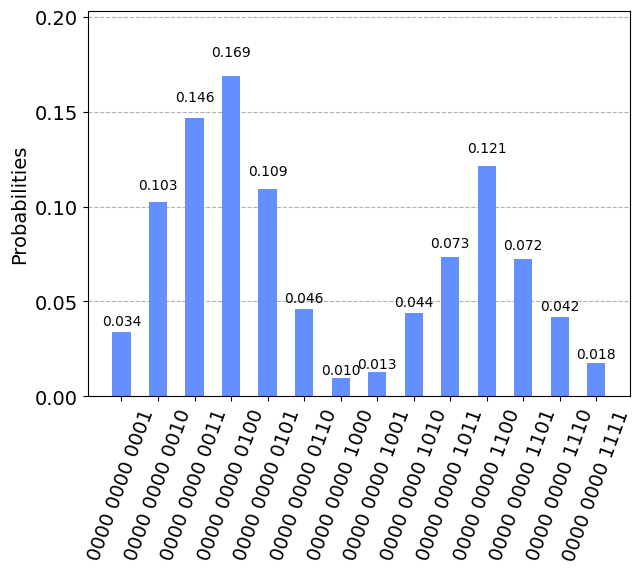

In [5]:
qc.measure(q_alice, c_alice)
plot_histogram(execute(qc, BasicAer.get_backend('qasm_simulator')).result().get_counts())

Cool hack is below:

In [6]:
# we remove the measurements for now to continue with the circuit building
# this is a hack to solve a problem with remove_final_measurements(), 
# which unfortunately removes BITS as well
qc._data = [instruction for instruction in qc._data if instruction[0].name != 'measure']

## [10] QFT

Then Alice wants to perform QFT of here data. Implement this action on Alice's qubits.

In [7]:
# TODO -- run QFT on Alice's qubits
qc.append(QFT(PROBLEM_SIZE), q_alice[:])

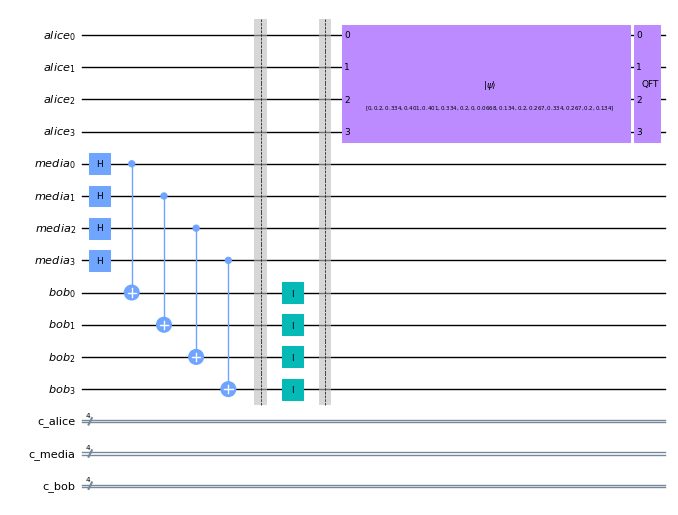

In [8]:
qc.draw('mpl', scale=.5)

The state now is the spectrum of the signal. Let us see what is it right before sending:

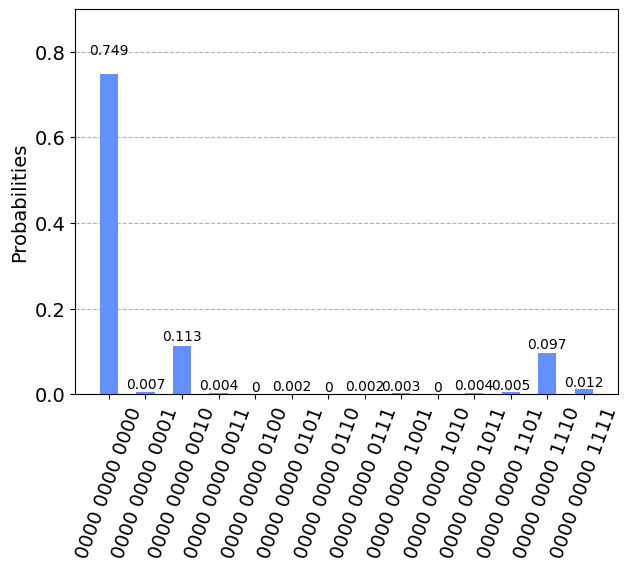

In [9]:
qc.measure(q_alice, c_alice)
plot_histogram(execute(qc, BasicAer.get_backend('qasm_simulator')).result().get_counts())

In [10]:
# we remove the measurements for now to continue with the circuit building
# this is a hack to solve a problem with remove_final_measurements(), which removes BITS also
qc._data = [instruction for instruction in qc._data if instruction[0].name != 'measure']
# qc.draw('mpl', scale=.5)

## Here we insert the data into the entagled channel

For this we will call the `reverse_entangle` function for all qubits pairs between Alice and media. You implemented this function above. Please feel free to change the order of qubits here in these call, if this somehow influences your solution below.

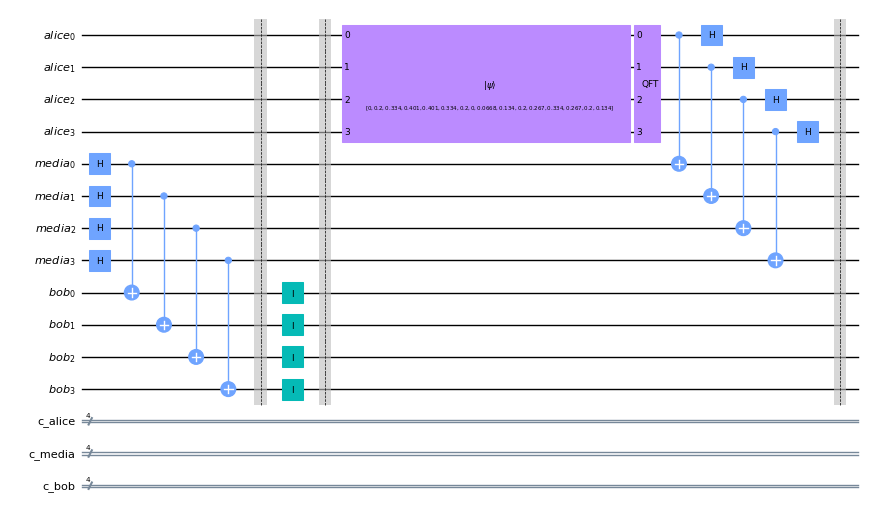

In [11]:
for a, b in zip(q_alice, q_media):
    reverse_entangle(qc, b, a)
    
qc.barrier()
qc.draw('mpl', scale=.5)

## Ready to send!

To "send" the data Alice has to imlements 2 things:
1. Measure her both quantum register to corresponding classical registers, and then send them to Bob.
2. Bob then will apply conditional (NOT CONTROLLED) `X`, conditioned by media measurements, and conditioned `Z`, conditioned by Alice's register measurements. 
   - NB - **Conditional** != **Controlled**; Conditional gates are subject to MEASUREMENT results (classical register), not quantum register. They are implemented using the [method `instruction.c_if(bit, value)`](https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.c_if.html).

After these actions Bob should obtain **the spectum** Alice has sent to him.

### [10] Alice measures

Alice here measures her qubits and media qubits into corresponding classical registers.

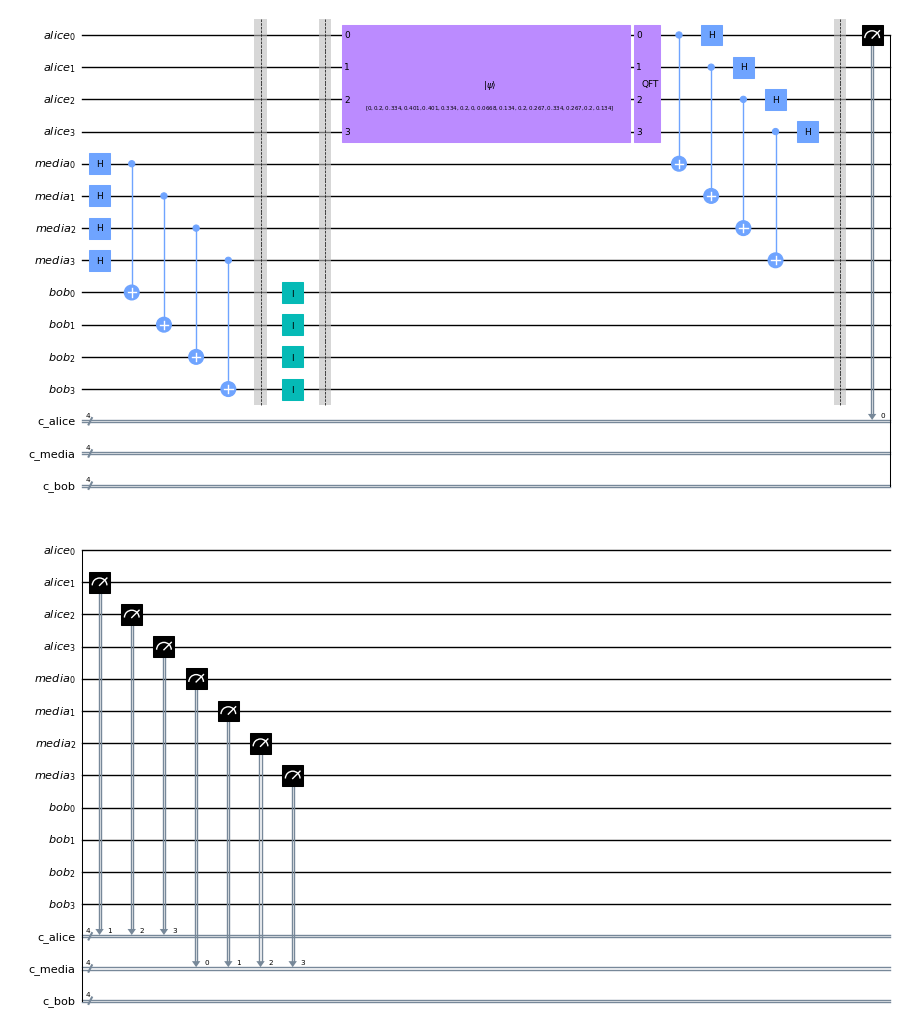

In [12]:
## TODO -- implement measurements here
qc.measure(q_alice[:], c_alice[:])
qc.measure(q_media[:], c_media[:])
qc.draw('mpl', scale=.5)

### [20] Bob applies conditional gates

After this operation Bob should have exactly what Alice teleported to him.

In [13]:
## Apply conditional X to Bob's qubits, with respect to media == 1
## Apply conditional Z to Bob's qubits, with respect to alice == 1

# TODO your code is here
for idx in range(PROBLEM_SIZE):
    qc.x(q_bob[idx]).c_if(c_media[idx], 1)
    qc.z(q_bob[idx]).c_if(c_alice[idx], 1)

Here Bob should obtain exactly te same spectrum as Alice had before measurement. This means teleport was successfull!

In [14]:
qc.measure(q_bob, c_bob)
counts = execute(qc, BasicAer.get_backend('qasm_simulator')).result().get_counts()

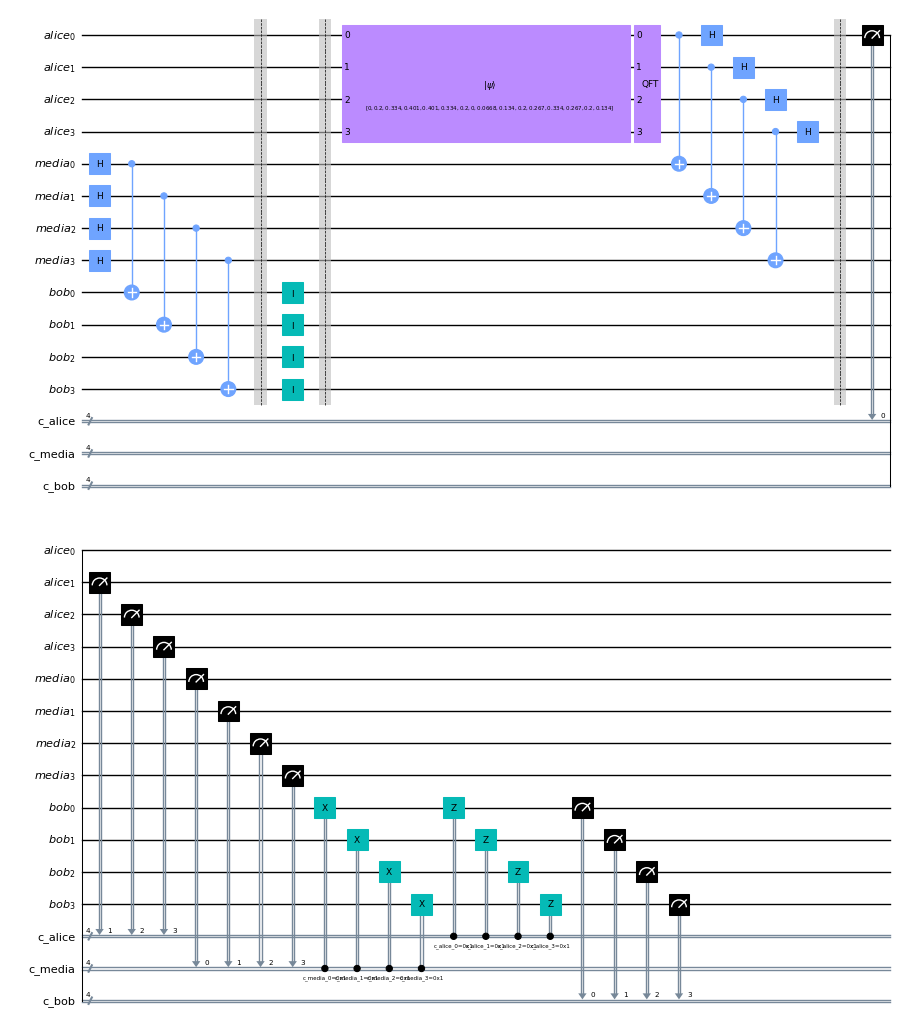

In [15]:
qc.draw('mpl', scale=.5)

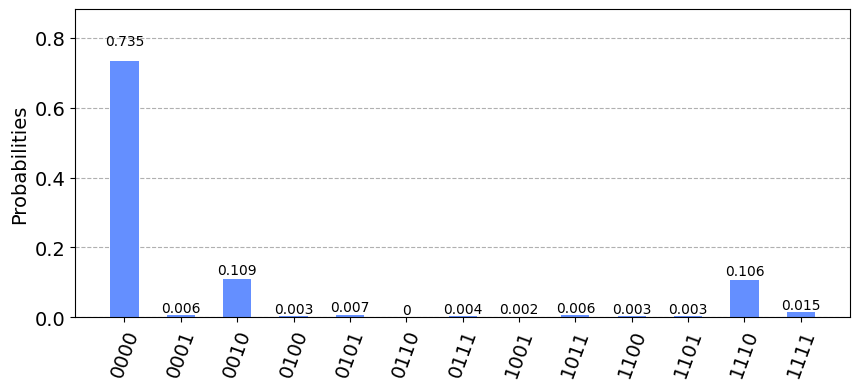

In [16]:
bobcounter = Counter()
[bobcounter.update({key[:PROBLEM_SIZE]:value}) for key, value in counts.items()]
plot_histogram(bobcounter, figsize=(10, 4))

/var/folders/mg/d6nn4rns19qf5xqv9lr7kvjr0000gn/T/ipykernel_16830/2068532678.py:4: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  or instruction[1][0].register.name != 'bob'


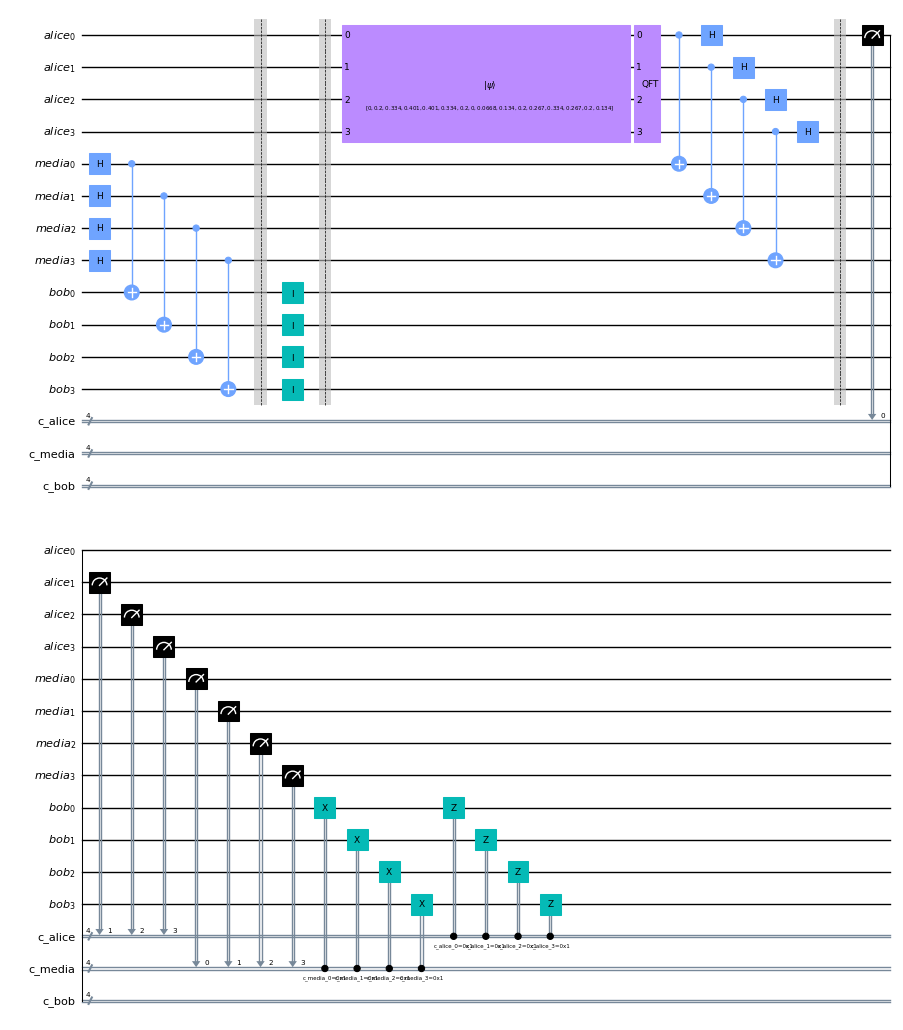

In [18]:
# here we remove final measurements
qc._data = [instruction for instruction in qc._data 
                if instruction[0].name != 'measure' 
                or instruction[1][0].register.name != 'bob'
           ]
qc.draw('mpl', scale=.5)

## [20] Bob decodes

But you remember that Bob needs the original data, not the spectrogram. Let him apply the inverse transformation to the data.

In [19]:
## TODO implements here inverse quantum Fourier transform on Bob's qubits
qc.append(QFT(PROBLEM_SIZE).inverse(), q_bob[:])

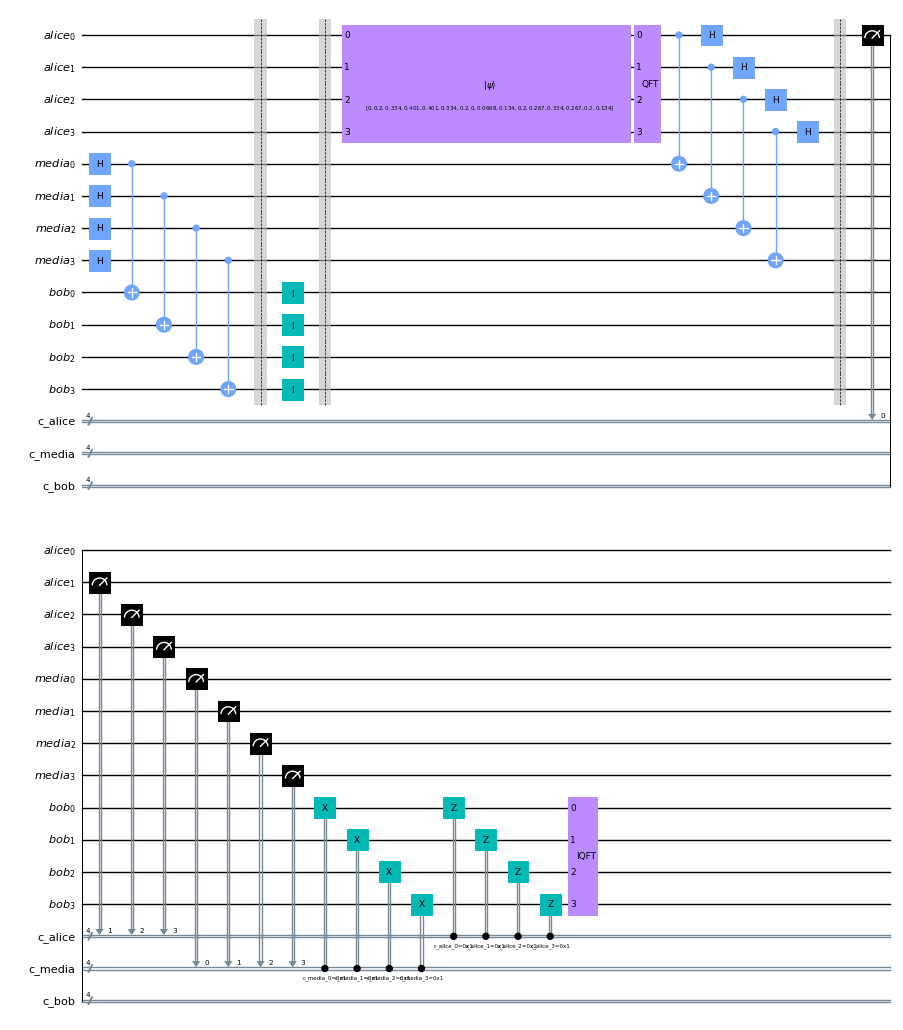

In [20]:
qc.draw('mpl', scale=.5)

In [21]:
qc.measure(q_bob, c_bob)
counts = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=1000).result().get_counts()

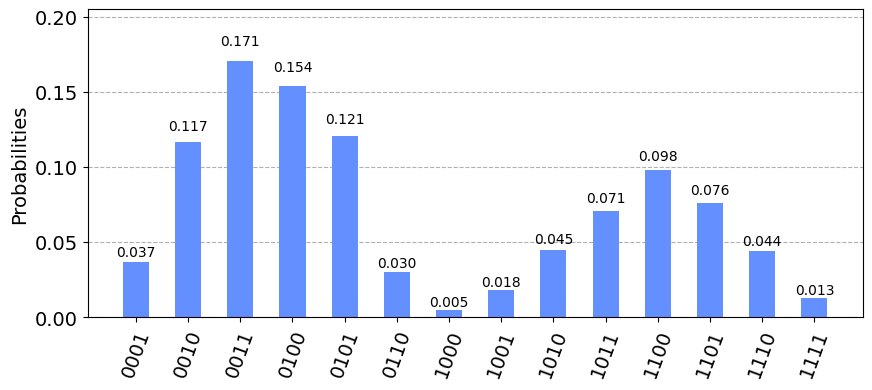

In [22]:
bobcounter = Counter()
[bobcounter.update({key[:PROBLEM_SIZE]:value}) for key, value in counts.items()]
plot_histogram(bobcounter, figsize=(10, 4))